# Experiment Data

New experiment data file. It seemed that the old one was a wrong input so now we have the new file from Lana.

In [2]:
### Auto reloading moduls
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from helpFunctions import *
from generateGLV import *
from fitGLV import *
from mpl_toolkits.mplot3d import Axes3D
import time
from matplotlib import gridspec

here is a code that plots 1 out of every 5 species: 

In [3]:
# Create the dataframe:
df_ts = {}

files = ['InputData/NewDavid_Data/25_timeseries.txt', 'InputData/NewDavid_Data/28_timeseries.txt']
keys = ['David_stool_A', 'David_stool_B']

for i, f in enumerate(files):
    x = pd.read_csv(f, na_values='NAN', delimiter='\t', header=None)
    x = x.T
    x.insert(0, 'time', range(len(x)))
    x.columns = ['time'] + ['species_%d' % j for j in range(1, len(x.columns))]
    df_ts[keys[i]] = x

Plot the data:

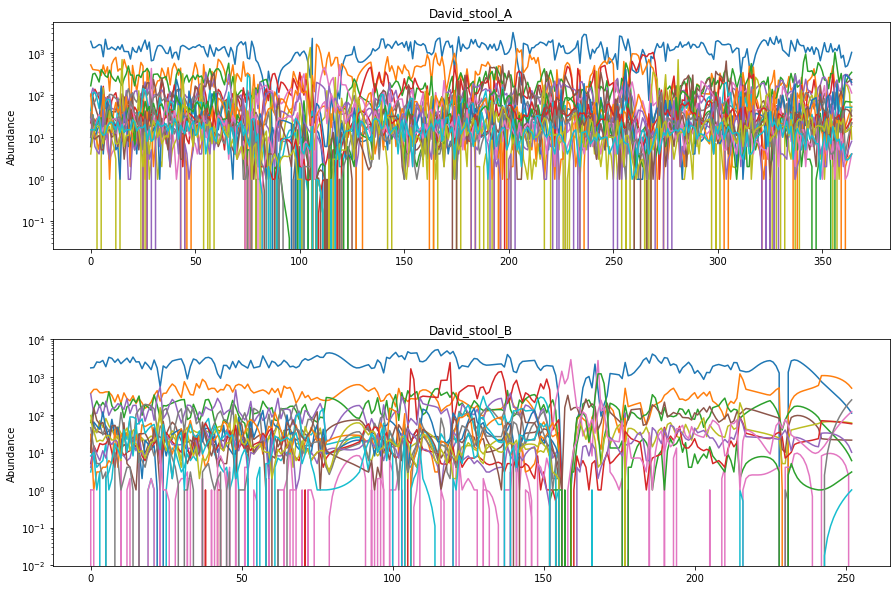

In [4]:
fig = plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(2,1,hspace=0.4)

for i, key in enumerate(keys):
    ax = fig.add_subplot(gs[i])
    ax.set_title(key)
    ax.plot(df_ts[key].time, df_ts[key].values[:,1::5],) # plot 1 species in 5
    ax.set_yscale('log')
    ax.set_ylabel('Abundance')

Data set two has a few issues.

for instance before teh 100. it seems to get streshed! And the last data points also do not seem to be correct. 

So lets first just focus on the Davis_stool_A. 

This is much nices and we see that the system most of the time pretty stable. Except for the living abroad then there is a significant influx of different which disturbs the system hard. We can either add or ignore in our data.

In [4]:
# Extract David stools data
x = pd.read_csv('InputData/NewDavid_Data/25_timeseries.txt', na_values='NAN', delimiter='\t', header=None)
TSDavidA = x.T.values

## Preprocess:

2 major things need to happen in preprocessing:

- Reduce the amount of species
- Flag pertubations regions such that we can remove them.

**Reducing species amount:**
We need to reduce the amount of species because else there are just way to much parameters and with only a limited amount of input data we will overfit.

1. Consider only species with non-zero abundancy (during the non-pertubation regions.
2. Consider only species with no invalid data (to not create continuity errors)
3. Take the only top $n$ species. THis can be a criterio on taking the species that constitute xx% of the abundancy. Or just a fixed $n$

**Flag pertubations:**

We need to flag pertubations such that they are not used in our analyis. For example the David_stool_A data has from roughly 75-125 a big pertubations because it has another diet. But taking this other diet it forces the system a pressure is created on the system such that the system takes a different form of community. This pressure is not something that the GLV can model hence these points would only confuse the model that we want to fit. So exclude these.

You can think of it as follows. You have intrinsic natural noise/ everyday noise which we explicitly model with our GLV and hence can account for. But cannot account for big outside/pertubations changes, this is noise not explicly modeled by the system and hence our fit will become bad. 

Flag noise regions with just a boolian vector such that we know when we create the data we do not consider those points.

## Flag pertubations:

Pertubations are flagged with an boolian vector.

In david A are the pertubation regions as follows: 
- Day 75 -> 125 it lived abroad
- Points 260-273 also maybe arguably
- Points 195-205 also maybe.

This was mainly derived by looking at the original paper.

In [5]:
# Rough edge of pertubation
PertuAbroad = np.full(len(TSDavidA)-1,False) # Only the abroad section 
PertuAbroad[73:125]=True

PertuAll = np.full(len(TSDavidA)-1,False)
PertuAll[73:125]=True
PertuAll[260:273]=True
PertuAll[195:205]=True

If we want to subset timeseries then the boolian is one to short Hence add increa the length by adding a False infront.

In [6]:
TSPertuAbroad = np.append(PertuAbroad,False)
TSPertuAll = np.append(PertuAll,False)

Plot it on the figure to see if we have the correct regions:

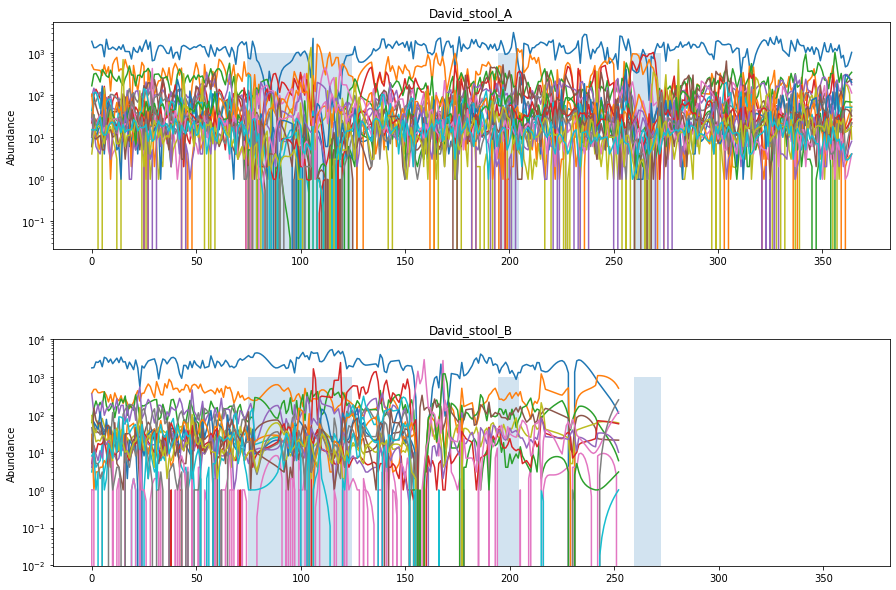

In [10]:
fig = plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(2,1,hspace=0.4)

for i, key in enumerate(keys):
    ax = fig.add_subplot(gs[i])
    ax.set_title(key)
    ax.bar(np.arange(len(PertuAll)),PertuAll*1000,width=1,alpha=0.2)
    ax.plot(df_ts[key].time, df_ts[key].values[:,1::5],) # plot 1 species in 5
    ax.plot()
    ax.set_yscale('log')
    ax.set_ylabel('Abundance')

## Remove species.

Firs gather some information about the total relatif abundnacy in the regions with PertuAbroad

In [6]:
print("25 Relatif abundancy all:")
print(np.round(np.sum(TSDavidA,axis=0)/np.sum(TSDavidA),4))
print("25 Without Going Abroad:")
print(np.round(np.sum(TSDavidA[~TSPertuAbroad],axis=0)/np.sum(TSDavidA[~TSPertuAbroad]),4))
print("25 Difference Abroad vs All:")
print(np.round((np.sum(TSDavidA[~TSPertuAbroad],axis=0)-np.sum(TSDavidA[~TSPertuAll],axis=0))/np.sum(TSDavidA[~TSPertuAll]),4))

25 Relatif abundancy all:
[0.1351 0.0721 0.0583 0.0538 0.0535 0.0346 0.0338 0.0331 0.0325 0.0209
 0.0209 0.0208 0.019  0.0181 0.0153 0.0144 0.0143 0.014  0.0128 0.0118
 0.0105 0.0105 0.01   0.0099 0.0098 0.0093 0.0086 0.0081 0.0079 0.0074
 0.0073 0.0071 0.0067 0.0063 0.0062 0.0057 0.0056 0.0053 0.0053 0.005
 0.0048 0.0045 0.0044 0.0044 0.0042 0.0041 0.0039 0.0039 0.0039 0.0039
 0.0038 0.0038 0.0037 0.0037 0.0036 0.0034 0.0034 0.0032 0.0032 0.0031
 0.003  0.003  0.003  0.003  0.003  0.0029 0.0026 0.0025 0.0025 0.0024
 0.0024 0.0023 0.0023 0.0022 0.002  0.002  0.002  0.002  0.0019 0.0019
 0.0019 0.0019 0.0019 0.0019 0.0018 0.0018 0.0018 0.0018 0.0017 0.0017
 0.0016 0.0016 0.0015 0.0015 0.0015 0.0014 0.0014 0.0014 0.0014 0.0014]
25 Without Going Abroad:
[0.146  0.0713 0.051  0.0458 0.0559 0.0339 0.0378 0.0351 0.033  0.0235
 0.0231 0.0211 0.0027 0.0188 0.014  0.0149 0.0162 0.0141 0.0133 0.011
 0.0115 0.0094 0.0112 0.0098 0.0102 0.0106 0.0092 0.0088 0.0084 0.0069
 0.006  0.0077 0.0076 0.006

Difference between pertu Abroad en All is not that much. Maximum 10% for some species.

The cumulatif:

In [7]:
print("25 Cumulatif Relatif abundancy:")
print(np.cumsum(np.sum(TSDavidA[~TSPertuAbroad],axis=0)/np.sum(TSDavidA[~TSPertuAbroad])))

25 Cumulatif Relatif abundancy:
[0.14596533 0.21729335 0.26830719 0.31406527 0.36996808 0.40383793
 0.44161957 0.47672222 0.50973725 0.5332635  0.55640388 0.57754106
 0.5802162  0.59905912 0.61305187 0.62795234 0.64410448 0.65818647
 0.67152158 0.68256124 0.69410313 0.70352533 0.71476413 0.72453957
 0.73476034 0.74536622 0.75461588 0.76338085 0.77173469 0.77865549
 0.78463674 0.79232288 0.79991257 0.80663043 0.81307141 0.81937842
 0.82551933 0.83135737 0.83710279 0.84263337 0.84688722 0.85097915
 0.85521593 0.85991085 0.8643761  0.86887294 0.87215552 0.87649517
 0.88058842 0.88416567 0.88825379 0.89231241 0.89503343 0.89845624
 0.90224196 0.90521971 0.90895982 0.9121573  0.91559186 0.91910103
 0.92256286 0.92575004 0.92866882 0.93139683 0.93458602 0.93784384
 0.94032709 0.94307442 0.94510194 0.94778911 0.94944072 0.95198034
 0.95452562 0.95690831 0.95907715 0.96118525 0.96273514 0.96338344
 0.96550686 0.96751153 0.96922727 0.97120919 0.97308133 0.97516234
 0.97718686 0.97921908 0.98099

It seems that all the low order have the same abundancy: +-0.02

Text(0, 0.5, 'Relatif abundancy')

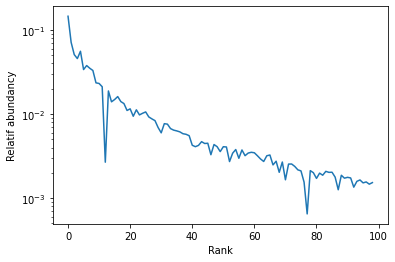

In [8]:
TSTotal = np.sum(TSDavidA[~TSPertuAbroad],axis=0)
RelatifTotal = TSTotal/np.sum(TSTotal)
plt.plot(RelatifTotal[RelatifTotal>0.0001]) # There is this one really low one.
plt.yscale("Log")
plt.xlabel("Rank")
plt.ylabel("Relatif abundancy")

We see that there is actually a very thick tail in the relatif abundancy -> Heavy rank distribution. So there are many species with low amount of abundancy but because of the think tail and not fast exponential decay you have to take many species before one achieves 90% abundance.

## Remove species that have zero.

Species that have a zero point cause many problems in the fitting and breaks the fitting. Thats why we do not like zero points.

So remove species that are zero in the region that we want to consider. For instance the most abundant species even go to zero when evaluated in the going abroad zone. So remove them:

[11 12 13 14 15 19 21 23 25 26 27 29 33 34 35 36 38 40 42 43 46 48 52 53
 55 59 60 62 66 68 69 70 71 73 74 75 76 77 81 82 83 84 86 87 88 89 90 91
 92 94 96 97 98 99]
Number of bad species = 54


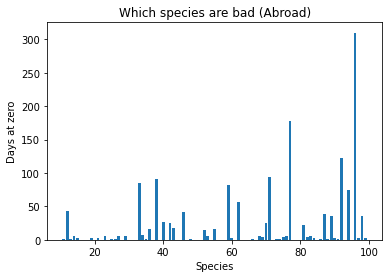

In [8]:
# Remove species that are zero at any point in the TS when not abroad
BadSpeciesAbroad = np.unique(np.where(TSDavidA[~TSPertuAbroad]==0)[1],return_counts=True)
plt.bar(BadSpeciesAbroad[0],BadSpeciesAbroad[1])
#plt.yscale("Log")
plt.xlabel("Species")
plt.ylabel("Days at zero")
plt.title("Which species are bad (Abroad)")
print(BadSpeciesAbroad[0])
print(f"Number of bad species = {len(BadSpeciesAbroad[0])}")

We see a hand full off species have many days with zero abundance (>10). But also many species with a just a few days (best seen in the log plot)

In [9]:
TSDavidA_GoodAbroad = np.delete(TSDavidA,BadSpeciesAbroad[0],axis=1)
BadSpeciesAllPertu = np.unique(np.where(TSDavidA[~TSPertuAll]==0)[1],return_counts=True)
TSDavidA_GoodAllPertu = np.delete(TSDavidA,BadSpeciesAllPertu[0],axis=1)

### How much abundancy did we remove?

In [11]:
totalAbu_NotAbroad = np.sum(TSDavidA[~TSPertuAbroad],axis=0)
RelTotalAbu_NotAbroad = totalAbu_NotAbroad/np.sum(totalAbu_NotAbroad)
PercentageAbuRemoved_Abroad = np.sum(RelTotalAbu_NotAbroad[BadSpeciesAbroad[0]])
print("Percentage abundancy removed by not considering the GoodNonAbroad species in the NonAbroad regime:")
print(np.round(RelTotalAbu_NotAbroad[BadSpeciesAbroad[0]],4))
print(PercentageAbuRemoved_Abroad)

totalAbu_AllPertu = np.sum(TSDavidA[~TSPertuAll],axis=0)
RelTotalAbu_AllPertu = totalAbu_AllPertu/np.sum(totalAbu_AllPertu)
PercentageAbuRemoved_AllPertu = np.sum(RelTotalAbu_AllPertu[BadSpeciesAllPertu[0]])
print("Percentage abundancy removed by not considering the GoodAllPertu species in the nonPertu regime:")
print(np.round(RelTotalAbu_AllPertu[BadSpeciesAllPertu[0]],4))
print(PercentageAbuRemoved_AllPertu)

Percentage abundancy removed by not considering the GoodNonAbroad species in the NonAbroad regime:
[0.0211 0.0027 0.0188 0.014  0.0149 0.011  0.0094 0.0098 0.0106 0.0092
 0.0088 0.0069 0.0067 0.0064 0.0063 0.0061 0.0057 0.0043 0.0042 0.0047
 0.0033 0.0041 0.0027 0.0034 0.003  0.0035 0.0035 0.0029 0.0025 0.002
 0.0027 0.0017 0.0025 0.0024 0.0022 0.0021 0.0015 0.0006 0.002  0.0019
 0.0021 0.002  0.0018 0.0013 0.0019 0.0017 0.0018 0.0017 0.0014 0.0016
 0.     0.0016 0.0015 0.0015]
0.25414001183073914
Percentage abundancy removed by not considering the GoodAllPertu species in the nonPertu regime:
[0.0024 0.0193 0.0137 0.0125 0.0106 0.0095 0.0093 0.0106 0.0088 0.007
 0.0069 0.0065 0.0065 0.0058 0.0041 0.0045 0.0047 0.0031 0.0042 0.0027
 0.0034 0.003  0.0033 0.0035 0.0028 0.0025 0.0021 0.0027 0.0017 0.0025
 0.0024 0.0021 0.0015 0.0006 0.002  0.0019 0.0021 0.0018 0.0013 0.0019
 0.0017 0.0018 0.0014 0.0017 0.     0.0016 0.0015 0.0015]
0.2090541671583137


We see that by removing the species we respectivly remove 25.5 and 20.9% of the total abundancy mass. This is certianly signifciant. But it also seems that this abundancy is heavy tailed and so we cannot quickly recover by just patching a few.

However when looking at how many points that it were zero:

In [12]:
BadSpeciesAbroad[1]

array([  1,  43,   1,   5,   3,   3,   3,   6,   1,   1,   5,   5,  85,
         7,   1,  16,  91,  27,  25,  18,  42,   1,  15,   5,  16,  82,
         2,  56,   1,   6,   4,  25,  94,   1,   1,   4,   6, 178,  22,
         4,   5,   3,   1,  39,   1,  36,   2,   1, 122,  75, 310,   2,
        35,   2])

We see that the 0.0213 removal is just 1 bad point. So maybe we can for some cases quick patch it. But how would you then to this? For now just ignore these.

## Take the first $n$ species ordered on total abundancy:

Now that we removed some species let's have a look again on how the rank distribution now looks like:

In [13]:
print("25 Cumulatif Relatif abundancy:")
TotalAbundancy_NonAbroad = np.sum(TSDavidA_GoodAbroad[~TSPertuAbroad],axis=0)
print(np.cumsum(TotalAbundancy_NonAbroad)/np.sum(TotalAbundancy_NonAbroad))

25 Cumulatif Relatif abundancy:
[0.19570071 0.29133262 0.35972863 0.42107806 0.49602886 0.54143932
 0.59209446 0.63915779 0.68342217 0.71496462 0.74598971 0.76764544
 0.78652564 0.80440447 0.81987908 0.83494731 0.84865065 0.85985092
 0.8678702  0.87817526 0.88835102 0.89617828 0.90359332 0.90907951
 0.91506623 0.92109529 0.92691361 0.93170975 0.93719083 0.94263236
 0.94770801 0.9527225  0.95700947 0.9616143  0.96588746 0.96954499
 0.97382086 0.97818873 0.98187217 0.98528471 0.98813166 0.99081938
 0.99311973 0.99584441 0.99796544 1.        ]


It looks like we are now much quicker to our 90 %, but this could also just be an effect

We ofcourse want to take the first $n$ sorted ones. Because we are only looking at the abundancy outside some pertubation region, the abundancy might now be ordered differently.

Make a list with the ordered species by abundancy and print it to compare:

In [14]:
highToLowAbu_NoAbroad = np.argsort(TotalAbundancy_NonAbroad)[::-1]
print(TotalAbundancy_NonAbroad)
print(highToLowAbu_NoAbroad)

[414227.0935   202417.9179   144769.4162   129854.39142  158643.535
  96117.41036  107218.47247   99615.92254   93691.54919   66763.87921
  65668.8131    45837.28318   39962.50335   37842.9745    32754.09997
  31893.96775   29004.97261   23706.90102   16973.876557  21812.0683
  21538.37231   16567.45831   15694.937225  11612.26478   12671.700699
  12761.335218  12315.25554   10151.686825  11601.446787  11517.73061
  10743.299077  10613.860299   9073.945891   9746.75276    9044.710355
   7741.670769   9050.446603   9245.199842   7796.491851   7223.113543
   6025.940781   5688.937416   4869.000887   5767.152127   4489.448433
   4306.421743]
[ 0  1  4  2  3  6  7  5  8  9 10 11 12 13 14 15 16 17 19 20 18 21 22 25
 24 26 23 28 29 30 31 27 33 37 32 36 34 38 35 39 40 43 41 42 44 45]


In [10]:
TotalAbundancy_NoPertu = np.sum(TSDavidA_GoodAllPertu[~TSPertuAll],axis=0)
highToLowAbu_NoPertu = np.argsort(TotalAbundancy_NoPertu)[::-1]
print(TotalAbundancy_NoPertu)
print(highToLowAbu_NoPertu)

[389234.4961   180832.5864   130930.3338   122981.81136  147518.6021
  86692.21336   99398.17382   94878.8151    88527.06552   60820.72965
  62878.05666   55032.73993   42276.02603   36316.50335   36123.3253
  31322.13929   30290.57754   26763.91339   24818.98597   21691.40102
  15772.376557  20560.19861   19224.54829   17062.39482   15319.18769
  14900.76844   10994.53152   12192.08217   12080.19028   11409.75554
   9726.186825  10988.446787  10894.62505   10267.670467  10096.79416
   8401.778461   8929.79553    8533.501356   7216.529439   8662.530185
   8535.14326    7155.898711   6603.186113   5792.822754   5443.084881
   5077.437416   4622.134595   5667.542842   5326.676787   4680.817276
   4070.082533   4075.491776]
[ 0  1  4  2  3  6  7  8  5 10  9 11 12 13 14 15 16 17 18 19 21 22 23 20
 24 25 27 28 29 26 31 32 33 34 30 36 39 40 37 35 38 41 42 43 47 44 48 45
 49 46 51 50]


Now take the first $n$

In [16]:
def takeFirstN_DavidA(n,PertuZone = "Abroad"):
    if PertuZone=="Abroad":
        return TSDavidA_GoodAbroad[:,highToLowAbu_NoAbroad[:n]]
    if PertuZone=="All":
        return TSDavidA_GoodAllPertu[:,highToLowAbu_NoPertu[:n]]
    
TSDavidA10Abroad = takeFirstN_DavidA(10)
TSDavidA10All = takeFirstN_DavidA(10,"All")

## Fitting results:

Fit results so far:

- Fitting all: Not possible because of the many invalid entries with the zero entries
- Fit first 10: Also not good because we had 0 and the ln did not like that
- first 10 with 75->125 removed:  :O We can with significance say that the self interaction is not zero. Growth is not signficant but they all fitted positive (except for one). Interaction terms cannot be fitted with significance

- Fits on the now better defined TSDavidA10Abroad and TSDavidA10All are really nice!. 

But important general conclusion is that we can fit the data! 

## Fit results TSDavidA10Abroad and TSDavidA10All:

In [17]:
data10Abroad = {}
data10Abroad["TS"] = TSDavidA10Abroad
data10Abroad["pertu"] = PertuAbroad # Do not uses the TSPertu! that was just introduced to work on davidTS
data10Abroad["normalise"] = False

data10All = {}
data10All["TS"] = TSDavidA10All
data10All["pertu"] = PertuAll
data10All["normalise"] = False

fit10Abroad = fitGLV(data10Abroad, typeInput="Experiment")
fit10All = fitGLV(data10All, typeInput="Experiment")

/home/lennart/Dropbox/VUB/2Ma Physics and Astronomy/MasterThesis/GitCode/PostFWO/fitGLV.py:174: RuntimeWarning: divide by zero encountered in log
  dln = np.diff(np.log(self.TS), axis=0)
/home/lennart/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:1269: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


Fit the objects and observe the fitted results:

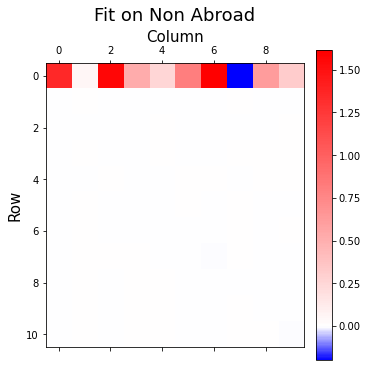

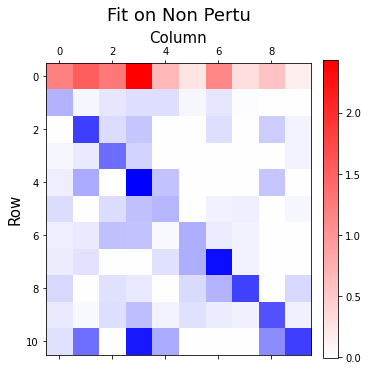

In [18]:
fit10Abroad.fitLinear()
fit10All.fitLinear()
plotM(fit10Abroad.BEst[0],"Fit on Non Abroad",mode="PosNeg")
plotM(fit10All.BEst[0],"Fit on Non Pertu",mode="PosNeg")

Apperantly in one of the pertubation regions there were some points that clearly confused the fit because we got a negative growth rate before. But now it moved away. 

**Important** the species are not in the same order! But it do are the same 10. For the (volg order) look at the 

Also note that the negtive regions in the second case is still really small!

**Interstingly!** All interaction terms are stricly negative !! -> Meaning purely competative case but this is inherently non stable! -> Not expected. So maybe the other species that we throw away are needed, Because else it would not stay stable and least one of the species would die. Or the system in herently does not follow the GLV and there is something we do not take into account for.

Now estimate the variance:

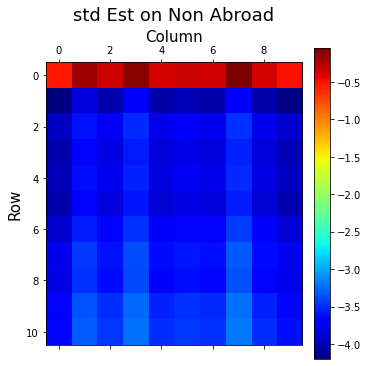

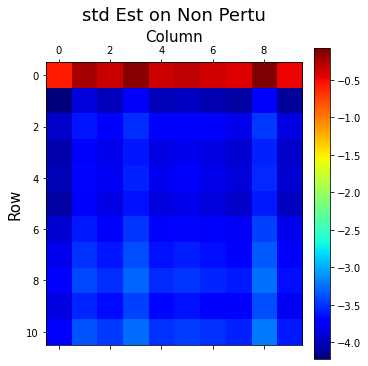

In [19]:
fit10Abroad.computeVarBEst()
fit10All.computeVarBEst()
plotM(np.log10(np.sqrt(fit10Abroad.varBEst[0])),"std Est on Non Abroad")
plotM(np.log10(np.sqrt(fit10All.varBEst[0])),"std Est on Non Pertu")

We see that the scale matches that of the absolute value of the inferred parameter.
Strangly it seems that the variance is less hard at the lower abundacy species. Could be to do something with the species.

Lastly we compute the null hypothesis.

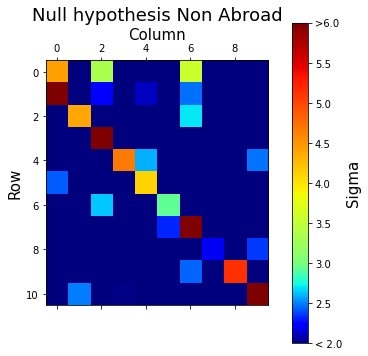

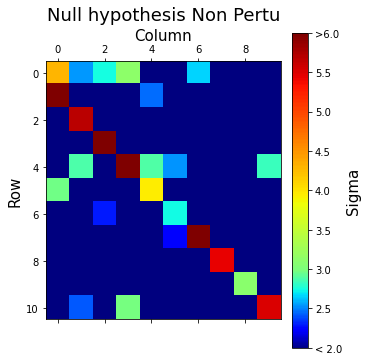

In [20]:
fit10Abroad.computeNullHypo()
fit10All.computeNullHypo()
plotM(fit10Abroad.pNullSigma[0],"Null hypothesis Non Abroad",mode="Sigma")
plotM(fit10All.pNullSigma[0],"Null hypothesis Non Pertu",mode="Sigma")

In both cases can we with significance we can infer the self interaction !!!

We see that with the Non pertu case that apperently we can infer some some pertubations with signifcance something that was not possible with the other!

We should be carefull that this is not duo that we now have less points and that we start to overfit (but we should be still far away from that so it should be ok !)


-----
In the analysis that follows we are considering the all pertubation region. And thus we will be using the data set: TSDavidA_GoodAllPertu which contains just the species of that are non zero outside the non perturbed regions.

## Relating to the simulations:

To be able to relate it with our simulations we need to normalise the data:

To normalise we need to divide the results by the steady state such that it is set to (1,...,1) Like before.

We estimate the steadystate to be the mean of the data (of the regions that we are considering not be pertuberd.)

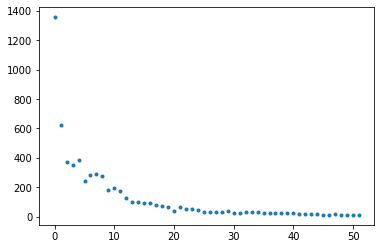

In [23]:
steadystate = np.median(TSDavidA_GoodAllPertu[~TSPertuAll],axis = 0)
plt.plot(np.arange(len(steadystate)), steadystate, ".")

Normalise the data by this value and make a plot again of the first 10 species to see how the timeseries now is:

In [24]:
TSNormalised = TSDavidA_GoodAllPertu/steadystate

(0.0, 3.0)

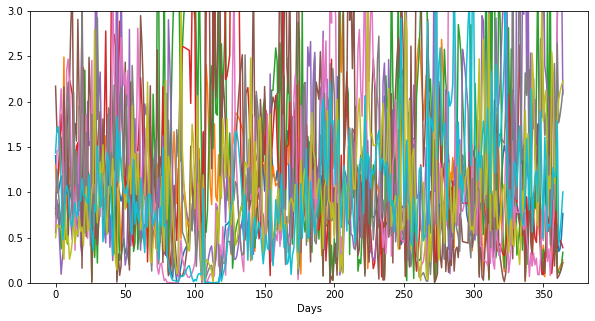

In [52]:
fig = plt.figure(figsize=(10,5))
plt.plot(np.arange(len(TSNormalised)), TSNormalised[:,:10])
plt.xlabel("Days")
plt.ylim(0,3)

We see that the time series goes wild. especially when going abroad, but we do not consider those cases.

Still we see that the noise goes wild, and actually we often see that the noise goes above two. Since species cannot go negative the noise is assymetrically larger towards positive outliers. Which is also inherently also with the linear langevin noise, but not as large as is observed here. 

Like the scale varies on the orders of magnitudes! 

So these extra high outliers could be duo extrinsic pertubations... Not so sure on how to interpret these timeseries.

----
Evalutating individual curves I observe the following:

- The first specie is (ok ish, still large deviations but roughly always between (0,3)
- The same can actually be said of the last species [-1], they behave the also roughly the same as the very first species
- The problem is mainly with the first species (not the very first) but the ones after that. Maybe that is why they also are ranked high, because these species seem to have huge outliers >3 frequently, which would indeed artificially increase them.

What I learned from this is maybe we should select species that behave correctly. -> But then again you artificially select a few species...

/home/lennart/Dropbox/VUB/2Ma Physics and Astronomy/MasterThesis/GitCode/PostFWO/fitGLV.py:174: RuntimeWarning: divide by zero encountered in log
  dln = np.diff(np.log(self.TS), axis=0)
/home/lennart/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:1269: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


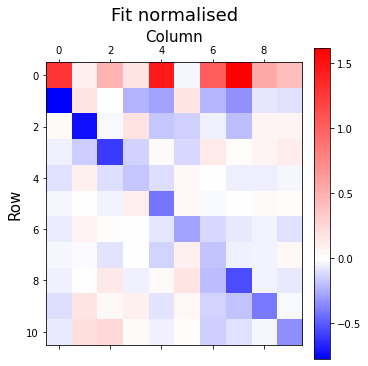

In [29]:
dataNorm10 = {}
dataNorm10["TS"] = TSNormalised[:,:10]
dataNorm10["pertu"] = PertuAll

fitNorm10 = fitGLV(dataNorm10, typeInput="Experiment") 
fitNorm10.fitLinear()
plotM(fitNorm10.BEst[0],"Fit normalised",mode="PosNeg")

Big impact -> Fitting the data resulted in now positive interaction terms! Which was not something before obsereved. Normalising the data had a clear influence on the fitting, not what like the theory predicted. 

-> Lets have a look at the fitting. 

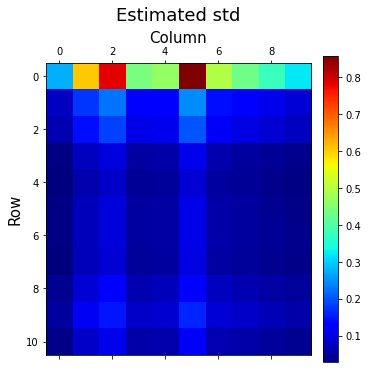

In [30]:
fitNorm10.computeVarBEst()
plotM(np.sqrt(fitNorm10.varBEst[0]),"Estimated std")

surprisingly the standard deviation is actually really low.

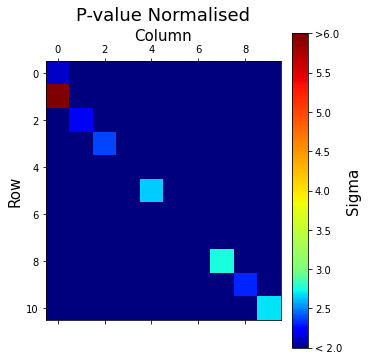

In [31]:
fitNorm10.computeNullHypo()
plotM(np.sqrt(fitNorm10.pNullSigma[0]),"P-value Normalised",mode="Sigma")

But apperently not low enough such that the normalisation is not wrong. We again see that the 

-> There is actually a big problem! our normalisation of the data has changed the p-value calculation ! which is NOT supposed to happen! 

We see that looking at the variance there seem to be two problem species: 2,5. Turns out that these are also precily the species with etremely large deviations!

Actually to estimate the variance of a species, one can just directly view the estimated std of each species:

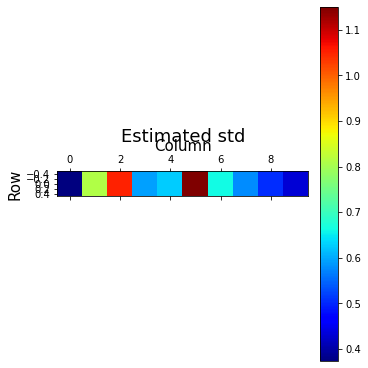

In [32]:
plotM(np.sqrt(fitNorm10.varEst),"Estimated std")

-> We see that we have three problem species with high variance: 2,3,5 (and maybe 6).

## Fit on All to see which species are problematic:

#### Some history:
We see clearly that some species have higher variance then others.. espcially species 2,3,6,11,12,13,30,31. Then there are some species that have a apprently invalid entries. Investigate closer:

It seems that the prediction those species where it goes wrong that an infinty snuck inthere: all the same place when looking with `fitNormAll.Y[:,:,40]` at place numbero 74. (Just before the abroad pertubation!).

Ok I found out. So indeed "outside the pertubation regions 74 is not zero. However, 75 IS for those species, and this is what cases the fault because to compute for Y[74] one needs to compute the ln of 75. -> Hence our pertubations region was to small!

I have updated the abroad region 75->73

#### Redo the analysis.

In [132]:
dataNormAll = {}
dataNormAll["TS"] = TSNormalised
dataNormAll["pertu"] = PertuAll

fitNormAll = fitGLV(dataNormAll, typeInput="Experiment") 
fitNormAll.computeNullHypo()

/home/lennart/Dropbox/VUB/2Ma Physics and Astronomy/MasterThesis/GitCode/PostFWO/fitGLV.py:174: RuntimeWarning: divide by zero encountered in log
  dln = np.diff(np.log(self.TS), axis=0)
/home/lennart/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:1269: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


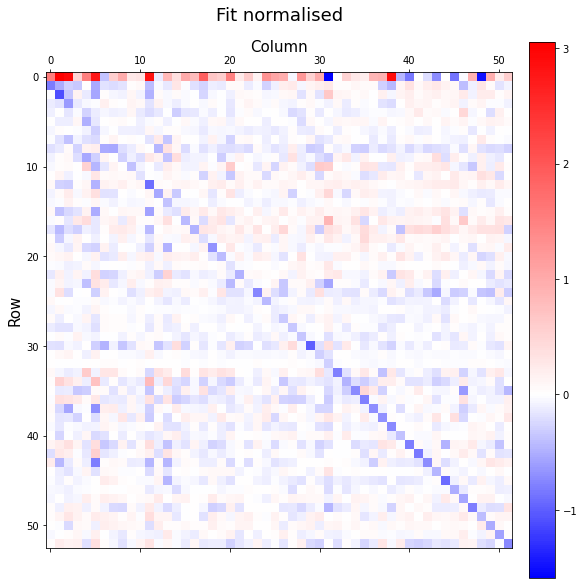

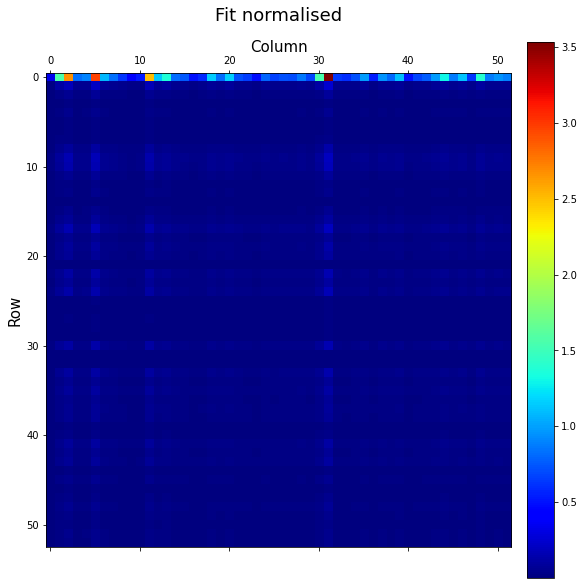

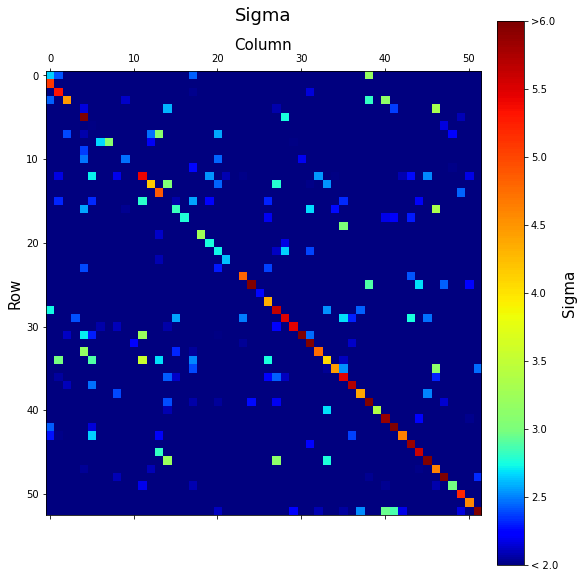

In [135]:
plotM(fitNormAll.BEst[0],"Fit normalised",mode="PosNeg",figsize=(8,8))
plotM(fitNormAll.varBEst[0],"estimated Std",figsize=(8,8))
plotM(fitNormAll.pNullSigma[0],"P-value Sigma",mode="Sigma",figsize=(8,8))

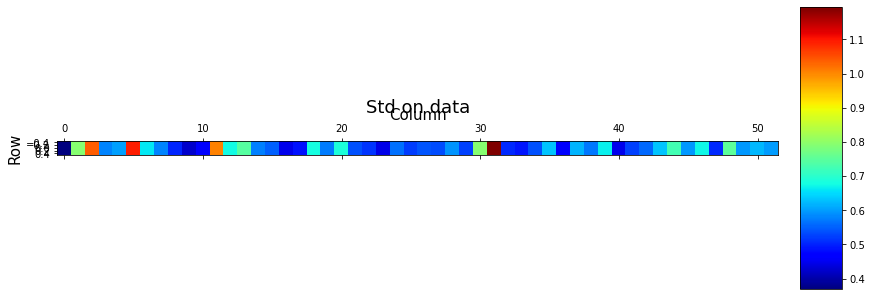

In [138]:
plotM(np.sqrt(fitNormAll.varEst),"Std on data",figsize=(12,4))

We see that the following species are problematic where $\sigma$>0.7

In [143]:
np.where(np.sqrt(fitNormAll.varEst[0])>0.7)

(array([ 1,  2,  5, 11, 13, 30, 31, 44, 48]),)

------
Lets do again the first 10 but now the first then that are not problamatic:

In [146]:
GoodFirst10 = (0,3,4,6,7,8,9,10,12,14)

In [147]:
dataNorm10GoodStd = {}
dataNorm10GoodStd["TS"] = TSNormalised[:,GoodFirst10]
dataNorm10GoodStd["pertu"] = PertuAll

fitNorm10GoodStd = fitGLV(dataNorm10GoodStd, typeInput="Experiment") 
fitNorm10GoodStd.computeNullHypo()

/home/lennart/Dropbox/VUB/2Ma Physics and Astronomy/MasterThesis/GitCode/PostFWO/fitGLV.py:174: RuntimeWarning: divide by zero encountered in log
  dln = np.diff(np.log(self.TS), axis=0)
/home/lennart/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:1269: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


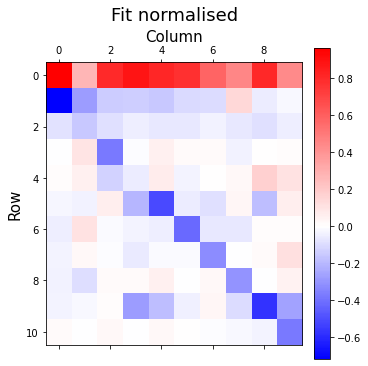

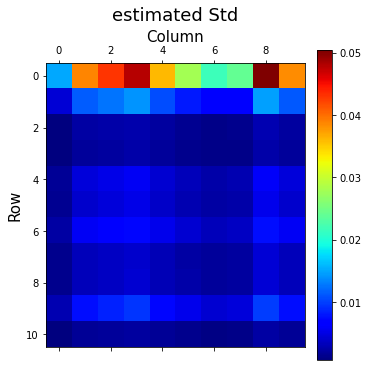

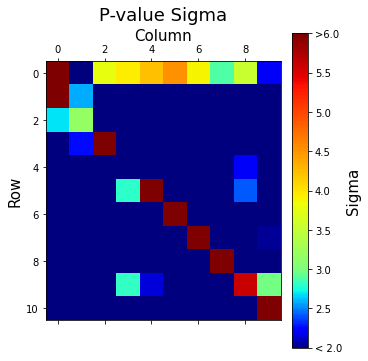

In [148]:
plotM(fitNorm10GoodStd.BEst[0],"Fit normalised",mode="PosNeg",figsize=(5,5))
plotM(fitNorm10GoodStd.varBEst[0],"estimated Std",figsize=(5,5))
plotM(fitNorm10GoodStd.pNullSigma[0],"P-value Sigma",mode="Sigma",figsize=(5,5))

We see that now the inference is much nicer. But this produces a problem. Because we should not chose our species just based on which inference gives us nicer results.

-> Also it seems that in whatever case we are not able to infer the interaction strenght with confidence. Maybe just a few paramters. But then it is to determine how much this is really because there interaction strength are really to be determined to be significant or its because of the data is had just some flukes which resulted in that fit.

----

If we are to believe the fits -> Then we should infer that interaction matrix is very sparse and not many can be determined to be significant.

It is nice to see that some off the significance paramters are found back in the original ALL sigma matrix.

For instance in the above figure for `fitNorm10GoodStd`. We see that in the see that in the second column 3 it is there is a signifcant interaction with row species column 4 and 8. This translates to species 6 is correlated with 7 and 12. Look at the fit of `fitNormAll` and we see indeed in that big fit we find back the signicant interaction with species 7, but not 12.

Another is the last column has a significant interaction with the one before. Species 14->12. This is also observed in the big fit!

So maybe indeed some species seem correlated. But some significant correlations seem to popup based on species selection. And this is in the cases that we through away 50 of the other species. :/ So not so sure yet.

-------

## All data but now with only good std species.

We saw that removing the problem species in the select 10 case improved the results. So lets do that again but now with only the species below the threshold of 0.7.

In [162]:
ThresholdSTD = 0.7
HighStdSpecies = np.where(np.sqrt(fitNormAll.varEst[0])>ThresholdSTD)
dataNormAllGoodStd = {}
dataNormAllGoodStd["TS"] = np.delete(TSNormalised, HighStdSpecies, axis=1)
dataNormAllGoodStd["pertu"] = PertuAll

fitNormAllGoodStd = fitGLV(dataNormAllGoodStd, typeInput="Experiment") 
fitNormAllGoodStd.computeNullHypo()

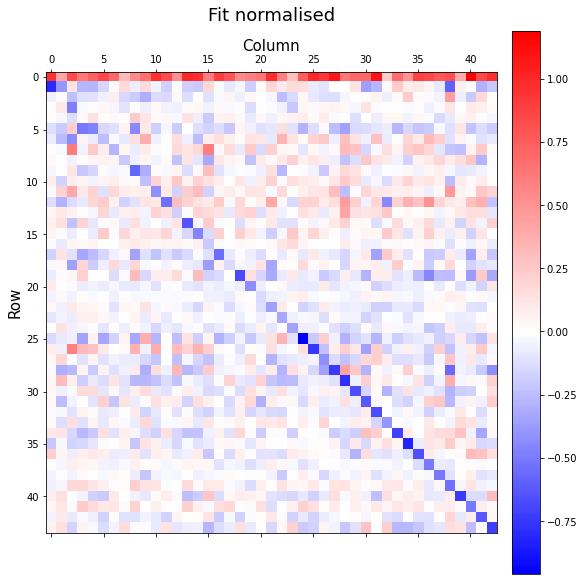

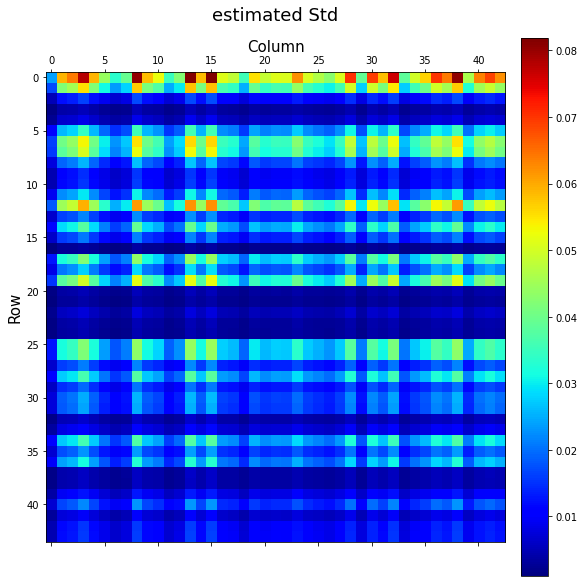

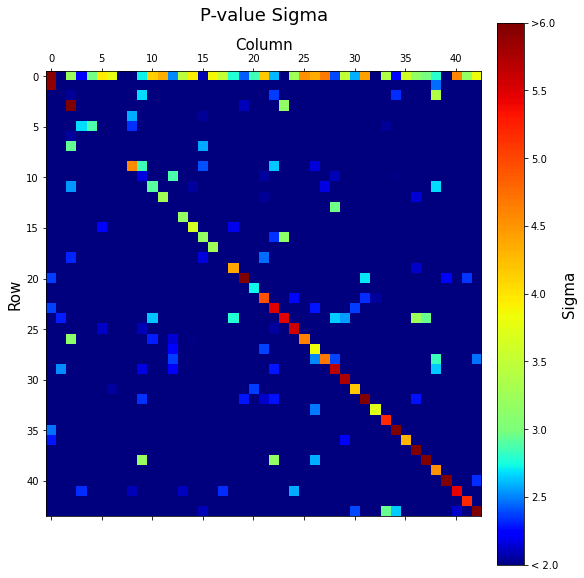

In [163]:
plotM(fitNormAllGoodStd.BEst[0],"Fit normalised",mode="PosNeg",figsize=(8,8))
plotM(fitNormAllGoodStd.varBEst[0],"estimated Std",figsize=(8,8))
plotM(fitNormAllGoodStd.pNullSigma[0],"P-value Sigma",mode="Sigma",figsize=(8,8))

Made observations:

- Varying the std threshold from 0.7 to 0.6 does not change the overall sigma null.
- We now again obsereve significant interactions of the growthrate! something that was gone with the to species that had a to large variance.
- The first couple of high abundnacy species do not seem to have a confident selfinteractions... really weird. Looking at the fitted value this seems to be coming from the fact that the fitted value is rather low. But they are still negatif!
- The low abundancy species always have a high significant self interaction. Again there fitted value is now rather high.
- This was also already observed with `fitNormAll` but now is observed again. There seems to be a bias towards positive interaction from the higher abundancy species in the differential equation of the lower abundancy. 
- There is this Region of Low standard deviation of like 5 species long. Both in 0.7,0.6. No idea where it comes from. This is not observed when looking at the estimated STD on the species data: (See below).
- Again the interaction matrix seems to be really sparse with only a couple of significant interactions springled throughout.

----

Just as a check, see what the estimated STD of the species is. They should not be larger then our threshold:

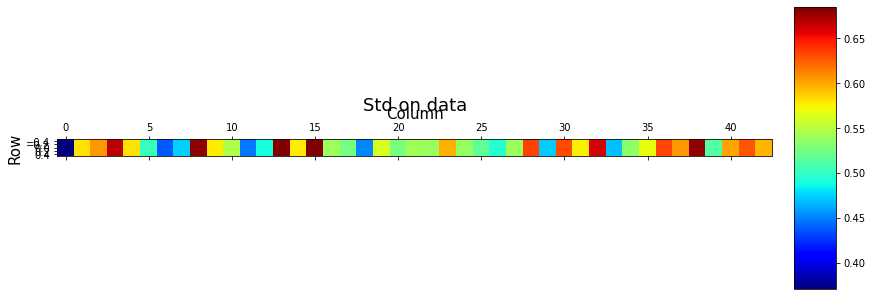

In [164]:
plotM(np.sqrt(fitNormAllGoodStd.varEst),"Std on data",figsize=(12,4))

Which is indeed what we observe!